# The Idea

Firstly, we change the architecture.
Secondly, we create new layer.

In [29]:
import jax 
import jax.numpy as np
import jax.scipy as sp
from jax import value_and_grad, grad, jit, vmap
from jax.example_libraries import optimizers
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

plt.style.use('dark_background')
background_color = tuple(onp.array([66, 68, 69])/255)
plt.rcParams['axes.facecolor'] = background_color
plt.rcParams['figure.facecolor'] = background_color

In [30]:
# class ParametricFunction:
#     def __init__(self, init_func, forward_func):
#         self.init_func = init_func
#         self.forward_func = forward_func
#     def init(self, key):
#         self.params = self.init_func(key)
#     def forward(self, X):
#         return self.forward_func(self.params, X)
#     def __add__(self, other):
#         def init_func(key):
#             k0, k1 = jax.random.split(key)
#             return (self.init_func(k0), other.init_func(k1))
#         def forward_func(params, X):
#             X = self.forward_func(self.params, X)
#             X = other.forward_func(other.forward_func, X)
#             return X
#         return ParametricFunction(init_func, forward_func)

In [814]:
def Dense(input_dim, output_dim, activation_function):
    def init(key):
        weight = jax.random.normal(key, shape=(input_dim, output_dim))/input_dim # /output_dim
        bias = np.zeros((output_dim,))
        return weight, bias
    def forward(params, X):
        weight, bias = params
        return activation_function(X @ weight + bias)
    return init, forward

In [815]:
def Sequential(*args):
    inits, forwards = zip(*args)
    def init(key):
        return [
            init(key)
            for init, key in zip(
                inits, 
                jax.random.split(key, len(inits))
            )
        ]
    def forward(params, X):
        for forward, params in zip(forwards, params):
            X = forward(params, X)
        return X
    return init, forward

In [816]:
def Residual(layer):
    init, forward = layer
    def residual_forward(params, X):
        return forward(params, X) + X
    return init, residual_forward 

In [1107]:
def ExpandSqueeze(inout_dim, hidden_dim, activation_function=lambda x: x):
    return Residual(Sequential(
        Dense(inout_dim, hidden_dim, jax.nn.relu),
        Dense(hidden_dim, hidden_dim, jax.nn.relu),
        Dense(hidden_dim, inout_dim, lambda x: x),
    ))

In [1109]:
def es_constraint(params):
    (w0, _), (w1, _), (w2, _) = params
    return (
        jax.nn.relu(np.linalg.norm(w0, ord=2) - 0.95) +
        jax.nn.relu(np.linalg.norm(w1, ord=2) - 0.95) +
        jax.nn.relu(np.linalg.norm(w2, ord=2) - 0.95)
    ) 
    
def constraint(params):
    return sum(es_constraint(p) for p in params)

def log_density(params, X):
    
    Z, pullback = jax.vjp(lambda X: forward(params, X), X)
    
    basis = np.eye(Z.shape[1], dtype=Z.dtype)[:,np.newaxis,:].repeat(Z.shape[0], axis=1)
    jac = vmap(pullback)(basis)[0].transpose((1,0,2))
    
    return sp.stats.norm.logpdf(Z).sum(axis=1) + np.log(np.abs(jax.vmap(np.linalg.det)(jac)))

def loss(params, X, C):
    weights = [p[0] for p in params]
    return -log_density(params, X).sum() + C*constraint(params)

In [1110]:
def sample_data(key, n, s=0.0):
    R = jax.random.normal(key, shape=(n, 3))
    return (R[:, 0].reshape(-1,1) + 3) * np.c_[np.sin(1*R[:,0]), np.cos(1*R[:,0])] + s*R[:, 1:]

In [1111]:
key = jax.random.PRNGKey(1022023)
X = sample_data(key, 1000, 0.2)

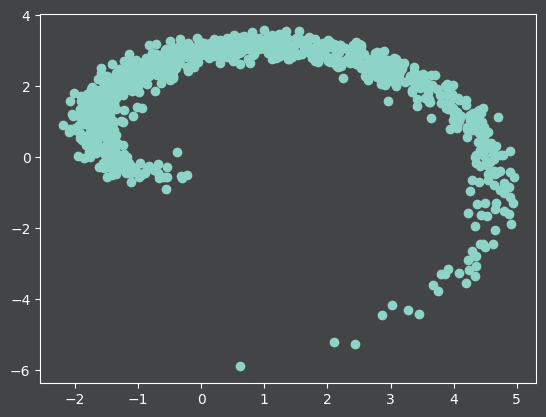

In [1112]:
plt.scatter(X[:,0], X[:,1])

In [1136]:
n = 16
init, forward = Sequential(
    ExpandSqueeze(2, n),
    ExpandSqueeze(2, n),
    ExpandSqueeze(2, n),
    ExpandSqueeze(2, n),
    ExpandSqueeze(2, n),
    ExpandSqueeze(2, n),
    ExpandSqueeze(2, n),
    ExpandSqueeze(2, n),
)

In [1133]:
key = jax.random.PRNGKey(5022023)
params = init(key)
losses = []

In [1134]:
learning_rate=0.01
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)

In [1135]:
key = jax.random.PRNGKey(1022023)
EPOCHS = 10000
batch_size = 128
C = 1000.5
jitvgloss = jit(lambda params: jax.value_and_grad(lambda params: loss(params, X, C))(params))

for epoch in (pbar := trange(EPOCHS)):
    
    key, subkey = jax.random.split(key)
    X = sample_data(key, batch_size, 0.2)
    value, grads = jitvgloss(get_params(opt_state))
    opt_state = opt_update(epoch, grads, opt_state)
    
    losses.append(value)
    pbar.set_description(f"{value:0.03f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

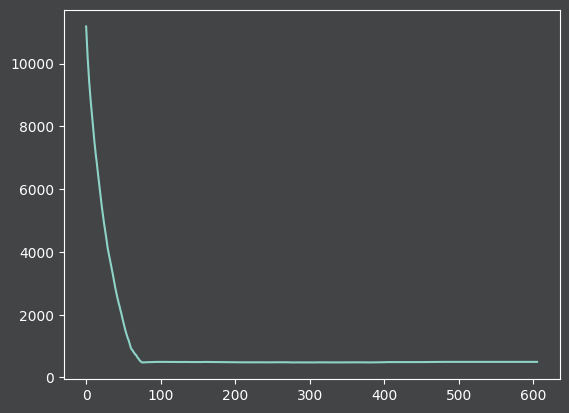

In [1147]:
plt.plot(losses)

In [1148]:
constraint(get_params(opt_state))

Array(0., dtype=float32)

In [1149]:
key = jax.random.PRNGKey(1022023)
Z = jax.random.normal(key, shape=(1000,2))

In [1150]:
_, g_forward = Sequential(
        Dense(1, 1, jax.nn.relu),
        Dense(1, 1, jax.nn.relu),
        Dense(1, 1, lambda x: x),
    )
def es_backward(layer, Z, n=16):
    Z_prev = Z
    for _ in range(n):
        Z_prev = Z - g_forward(layer, Z_prev)
    return Z_prev

def backward(params, Z, n=16):
    for layer in reversed(params):
        Z = es_backward(layer, Z, n)
    return Z

In [1151]:
Xhat = backward(get_params(opt_state), Z, 160)

In [1152]:
Xhat

Array([[ 3.1061118 ,  2.316548  ],
       [-3.285008  ,  0.87136066],
       [ 1.6345294 ,  3.3462992 ],
       ...,
       [-1.1347481 ,  4.351881  ],
       [-1.7294512 ,  0.21517974],
       [-2.3476532 ,  2.328193  ]], dtype=float32)

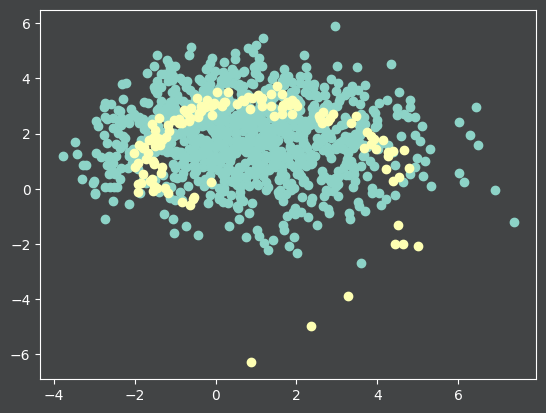

In [1153]:
plt.scatter(Xhat[:,0], Xhat[:,1])
plt.scatter(X[:,0], X[:,1])
# plt.xlim(-6,6)
# plt.ylim(-6,6)

In [1154]:
for p in get_params(opt_state):
    for g in p: 
        # print(np.linalg.norm(g[0], ord=2))
        pass
        # print(np.linalg.det(g[0]))
    a = p[0][0] @ p[1][0] @ p[2][0]
    print(np.linalg.norm(a, ord=2))

0.5683106
0.26127416
0.21982597
0.11244676
0.27607045
0.26814413
0.36234593
0.21910845


In [1155]:
_, g_forward = Sequential(
    Dense(1, 1, jax.nn.relu),
    Dense(1, 1, jax.nn.relu),
    Dense(1, 1, lambda x: x),
)
def check_lipschitz(params, X):
    Z, pullback = jax.vjp(lambda X: g_forward(params, X)-X, X)
    
    basis = np.eye(Z.shape[1], dtype=Z.dtype)[:,np.newaxis,:].repeat(Z.shape[0], axis=1)
    jac = vmap(pullback)(basis)[0].transpose((1,0,2))
    
    return vmap(lambda x: np.linalg.norm(x, ord=2))(jac).max()
    

In [1156]:
A = jax.random.normal(key, shape=(1000,2))
[check_lipschitz(p, A) for p in get_params(opt_state)]

[Array(1.1885111, dtype=float32),
 Array(1.2635199, dtype=float32),
 Array(1.1947954, dtype=float32),
 Array(1.0447743, dtype=float32),
 Array(1.0871966, dtype=float32),
 Array(1.1732287, dtype=float32),
 Array(1.0400273, dtype=float32),
 Array(1.0697086, dtype=float32)]